In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import os
import numpy.linalg as la

import sklearn.linear_model

import matplotlib.pyplot as plt
%matplotlib inline

# Trip distribution

The purpose of this notebook is to learn how to work with simple gravity models for trip distribution.

First, let's load the population, commuting, and municipality data from the first exercise:

In [2]:
df_employment = pd.read_parquet("employment.parquet")
df_commutes = pd.read_parquet("commutes.parquet")

# geopandas
df_municipalities = gpd.read_parquet("municipalities.parquet")

**Task**: As before, reduce all data sets to the area of Île-de-France.

In [3]:
idf_departments = ["75", "92", "93", "94", "95", "77", "91", "78"]

In [4]:
# Insert code here ...
# ...

df_employment = df_employment[df_employment["municipality_id"].str[:2].isin(idf_departments)]
df_municipalities = df_municipalities[df_municipalities["municipality_id"].str[:2].isin(idf_departments)]

df_commutes = df_commutes[
    df_commutes["origin_id"].str[:2].isin(idf_departments) &
    df_commutes["destination_id"].str[:2].isin(idf_departments)
]

**Task**: Keeping track of the order of the data will be important. Set up a fixed list of municipalities and adjust the indices of all data sets. Especially, take care of the commuting data set.

Hint: Make use of `pd.MultiIndex.from_product`

In [5]:
# Insert code here ...
# ...

# municipalities = 

# df_emloyment = 
# df_commutes = 

municipalities = df_municipalities["municipality_id"].unique()

df_employment = df_employment.set_index("municipality_id").reindex(municipalities)

df_commutes = df_commutes.set_index(["origin_id", "destination_id"]).reindex(
    pd.MultiIndex.from_product([municipalities, municipalities], names = ["origin_id", "destination_id"]))

Have a look at your data sets after reindexing, do you notice anything special?

**Task**: How many flow values can we theoretically have (between all zones) in Île-de-France? For how many do we have actual values?

In [6]:
# Insert code here ...
# ...

len(df_commutes), np.count_nonzero(~df_commutes.isna()), np.count_nonzero(~df_commutes.isna()) / len(df_commutes)

(1656369, 123787, 0.07473395119082765)

**Task**: Replace missing values by zero (zero commuters).

In [7]:
# Insert code here ...
# ...

df_commutes["weight"] = df_commutes["weight"].fillna(0.0)

## Friction term

The first step in setting up our model is to obtain the friction term.

**Task**: The gravity model puts into relation different places in the study area. The friction term describes how easy it is to reach one municipality from another one. The first step is, therefore, to obtain the distances between all zones. Complete the following code to set up a distance matrix `distance_matrix`.

In [8]:
centroids = df_municipalities["geometry"].centroid
centroids = np.array([centroids.x, centroids.y] ).T

distance_matrix = np.zeros((len(municipalities), len(municipalities)))

for k in range(len(municipalities)):
    # distance_matrix[k,:] = # Calculate the Euclidean distance, you may also try numpy.linalg.norm
    
    distance_matrix[k,:] = la.norm(centroids[k] - centroids, axis = 1)

**Task:** Plot the distance matrix (it may take a while)

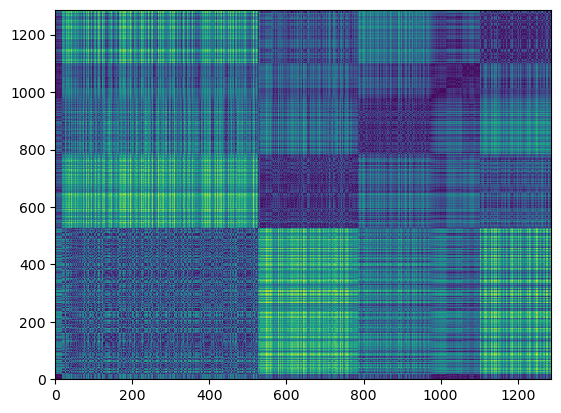

In [9]:
plt.pcolor(distance_matrix)

**Task**: Analogously to the distance matrix, we need a flow matrix indicating all observed movements (`weight`) between all zones. Obtain this matrix by transforming the commuting data set into a matrix.

Hint: Have a look at `numpy.ndarray.reshape`

In [10]:
# Insert code here ...
# ...

# flow_matrix = 

flow_matrix = df_commutes["weight"].values.reshape((len(municipalities), len(municipalities)))

**Task**: Now we obtain the data to set up the friction model:
- Bin the distances into about twenty distance bins and sum up the commuters you find in each distance bin
- Plot how much flow occurs at every distance bin

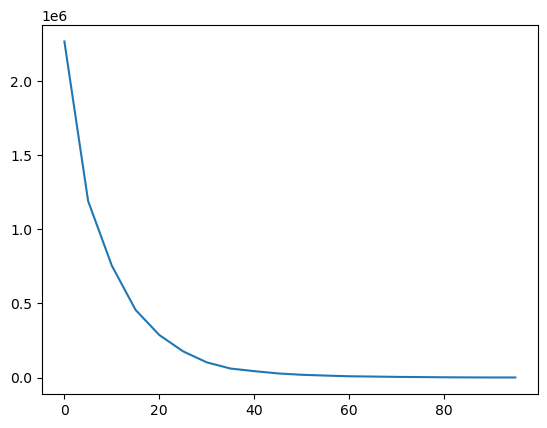

In [11]:
df_friction = pd.DataFrame({
    "distance": distance_matrix.flatten(),
    "flow": flow_matrix.flatten()
})

distance_classes = np.arange(20) * 5000

# Hint: Check numpy.digitize

# Insert code here ...
# ...

df_friction["distance_class"] = np.digitize(df_friction["distance"], distance_classes)
df_friction = df_friction.groupby("distance_class")["flow"].sum().reset_index()

plt.plot(distance_classes * 1e-3, df_friction["flow"].values)

**Task**: Now divide the obtained flow in each bin by the total flow, to obtain an empirical probability density function (pdf). Plot the function in absolute coordinates and with the probability logarithmized. What do you observe?

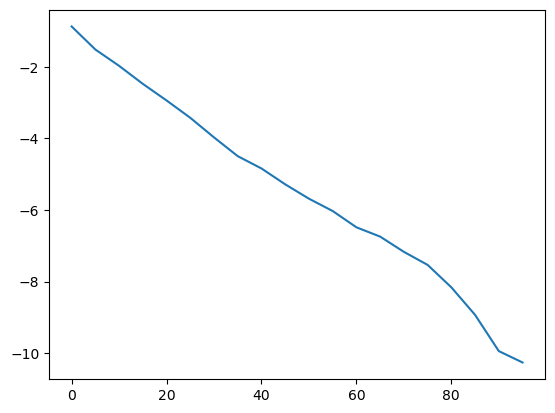

In [12]:
# Insert code here ...
# ...

# pdf = 

pdf = df_friction["flow"].values / df_friction["flow"].sum()
plt.plot(distance_classes * 1e-3, np.log(pdf))

**Task**: In logarithmic space, manually (or automatically, if you like), fit a linear function on the graph that you see.

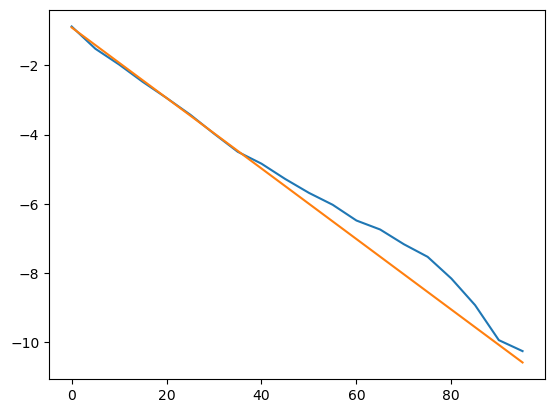

In [13]:
# Insert code here ...
# ...

# a = ?
# b = ?

# logy = a + b * np.log(pdf)

a = -0.9
b = -1.02e-4

logy = a + b * distance_classes

plt.plot(distance_classes * 1e-3, np.log(pdf))
plt.plot(distance_classes * 1e-3, logy)

**Task**: Now plot the initial data along with your fitted curve in linear space. How does you friction model look like?

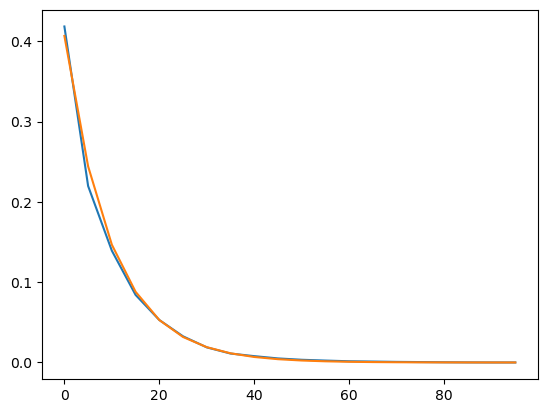

In [14]:
# Insert code here ...
# ...

a = -0.9
b = -1.02e-4

logy = a + b * distance_classes

plt.plot(distance_classes * 1e-3, pdf)
plt.plot(distance_classes * 1e-3, np.exp(logy))

**Task**: Based on your distance matrix and your friction model, calculate a friction matrix:

In [15]:
# Insert code here ...
# ...

# friction_matrix = 

friction_matrix = np.exp(a + b * distance_matrix)

## Single-constrained gravity model

Based on the friction model, it is now possible to set up a single-constrained gravity model.

As in the example during the lecture, we assume the following attraction model:

$$
A_i = w_i^\lambda
$$

with $w_i$ being the employment in zone $i$ and $\lambda$ the parmeter we need to obtain.

**Task**: For a parameter of $\lambda = 0.5$ calculate the attraction term. Treat NaN values as "no emloyment" (= 0).

In [16]:
# Insert code here ...
# ...

# attraction = 

employment = df_employment["employment"].values
employment[np.isnan(employment)] = 0

attraction = employment**0.5

**Task**: The single-constrained gravity model is defined as

$$
F_{ij} = \frac{A_j \cdot \rho_{ij}}{\sum_j A_j \cdot \rho_{ij}} O_i
$$

The friction term $\rho_{ij}$ is already known in our example. $A_j$ has been calculated in the last task for one specific parameter $\lambda$. As the next exercise, calculate $F_{ij}$ according to the formula above.

In [17]:
origins = np.sum(flow_matrix, axis = 1)

F = np.zeros((len(municipalities), len(municipalities)))

# Insert code here ...
# ...

#for i in range(len(municipalities)):
    # nominator =
    # denominator =

    # F[i,:] = 

for i in range(len(municipalities)):
    nominator = attraction * friction_matrix[i]
    denominator = np.sum(nominator)

    F[i,:] = origins[i] * nominator / denominator

**Task**: Create a scatter plot where you compare the obtained flows $F_{ij}$ with the reference flows. Think about how to reshape the matrix.

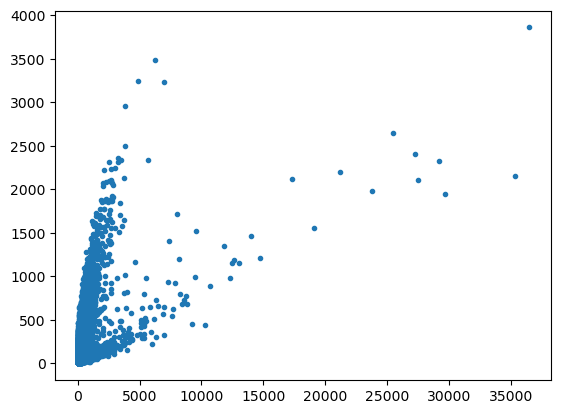

In [18]:
df_comparison = df_commutes.copy()

# Insert code here ...
# ...

plt.plot(flow_matrix.flatten(), F.flatten(), ".")

**Task**: Now wrap the code of the last cells in a loop and test various values for $\lambda$. Plot the difference with the reference data $\sum_{ij} (F_{ij} - \hat F_{ij})^2$ as a function of $\lambda$

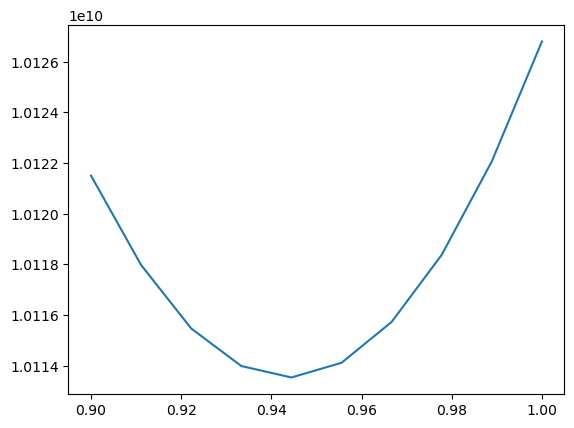

In [19]:
# Insert code here ...
# ...

# lambdas = np.linspace(0.1, 2.0, 10)
# objectives = []

# for lbda in lambdas:
    # ...

lambdas = np.linspace(0.9, 1.0, 10)
objectives = []

for lbda in lambdas:
    attraction = employment**lbda

    F = np.zeros((len(municipalities), len(municipalities)))

    for i in range(len(municipalities)):
        nominator = attraction * friction_matrix[i]
        denominator = np.sum(nominator)
    
        F[i,:] = origins[i] * nominator / denominator

    objectives.append(np.sum((F - flow_matrix)**2))

plt.plot(lambdas, objectives)

**Task**: Using the obtained parameter, calculate the resulting flow matrix from your model, then perform a scatter plot again to see the model fit. 

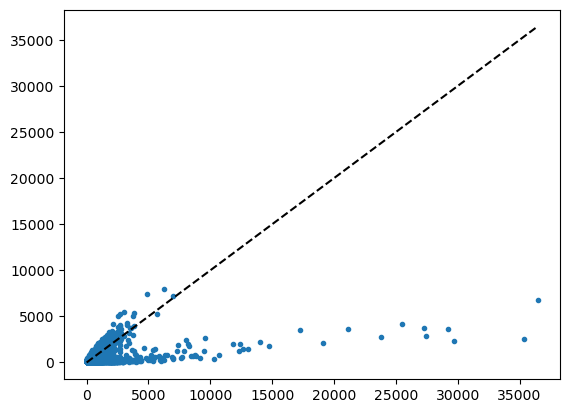

In [20]:
# Insert code here ...
# ...

F = np.zeros((len(municipalities), len(municipalities)))
attraction = employment**0.945

new_friction = friction_matrix # + 12 * np.eye(len(municipalities))

for i in range(len(municipalities)):
    nominator = attraction * new_friction[i]
    denominator = np.sum(nominator)

    F[i,:] = origins[i] * nominator / denominator

plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

What do you observe? Which municipalities could be the outliers on the bottom?

**Task**: Provide the same plot and color the flows in red which go from one municipality to itself.

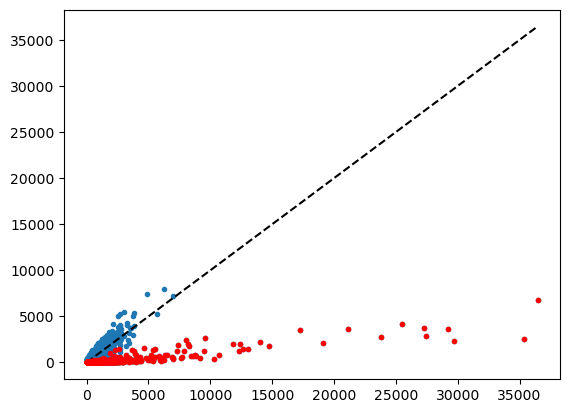

In [21]:
# Insert code here ...
# ...

F = np.zeros((len(municipalities), len(municipalities)))
attraction = employment**0.945

for i in range(len(municipalities)):
    nominator = attraction * friction_matrix[i]
    denominator = np.sum(nominator)

    F[i,:] = origins[i] * nominator / denominator

plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

indices = np.arange(len(municipalities)) * len(municipalities) + np.arange(len(municipalities))
plt.plot(flow_matrix.flatten()[indices], F.flatten()[indices], "r.")

**Task**: Try to estimate a new model using the following modified friction term:

$$
F_{ij} = \begin{cases}
    w_i^\lambda & \text{if} i \neq j \\
    w_i^\lambda + \gamma & \text{if} i = j
\end{cases}
$$

Which parameters $\lambda$ and $\gamma$ work best?

Hint: Keep your existing friction matrix in `friction_matrix` and create new matrices on the fly for testing.

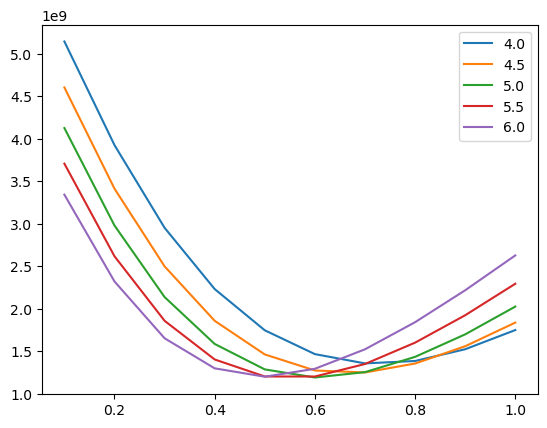

In [22]:
# Insert code here ...
# ...

gammas = np.linspace(4, 6, 5)

for gamma in gammas:
    lambdas = np.linspace(0.1, 1.0, 10)
    objectives = []

    updated_friction_matrix = friction_matrix + np.eye(len(municipalities)) * gamma
    
    for lbda in lambdas:
        attraction = employment**lbda
    
        F = np.zeros((len(municipalities), len(municipalities)))
    
        for i in range(len(municipalities)):
            nominator = attraction * updated_friction_matrix[i]
            denominator = np.sum(nominator)
        
            F[i,:] = origins[i] * nominator / denominator
    
        objectives.append(np.sum((F - flow_matrix)**2))
    
    plt.plot(lambdas, objectives, label = str(gamma))

plt.legend()

**Task**: Show the fit of your new model in a scatter plot.

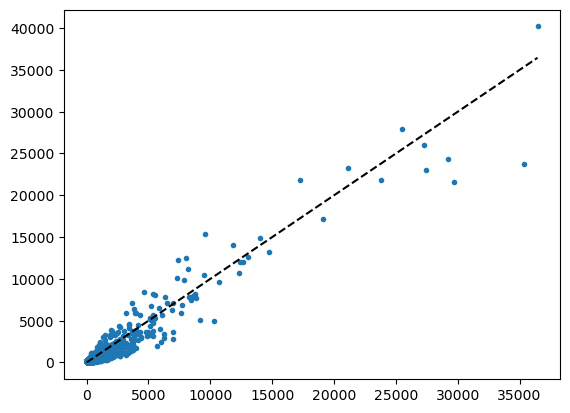

In [23]:
# Insert code here ...
# ...

F = np.zeros((len(municipalities), len(municipalities)))
attraction = employment**0.6
updated_friction_matrix = friction_matrix + np.eye(len(municipalities)) * 5.0

for i in range(len(municipalities)):
    nominator = attraction * updated_friction_matrix[i]
    denominator = np.sum(nominator)

    F[i,:] = origins[i] * nominator / denominator

plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

**Task**: Create also scatter plots for the fit in terms of origin counts and destination counts. What do you expect? What do you observe?

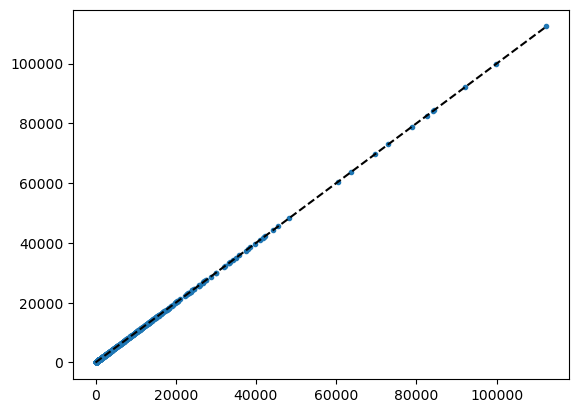

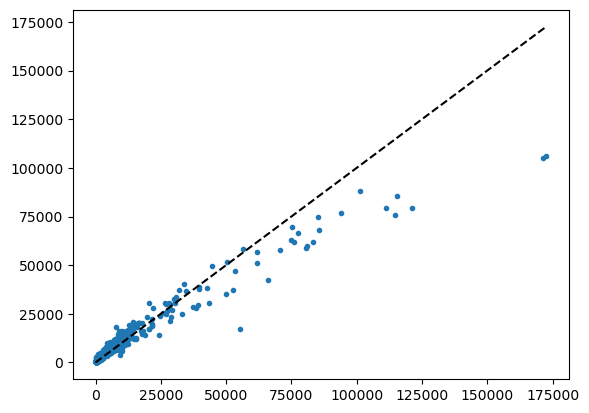

In [24]:
# Insert code here ...
# ...

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 1), np.sum(F, axis = 1), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 1))], [0, np.max(np.sum(flow_matrix, axis = 1))], "k--")

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 0), np.sum(F, axis = 0), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 0))], [0, np.max(np.sum(flow_matrix, axis = 0))], "k--")

What do you observe?

## Double-constrained gravity model

Let's move on to the double-constrained model. In that model, both the origin and destination flows $O_i$ and $D_j$ are known and we aim to automatically find the attraction and production terms $A_j$ and $P_i$.

The model is defined as follows:

$$
F_{ij} = \frac{O_i \cdot D_i}{(\sum_i P_i \cdot \rho_{ij})\cdot (\sum_j A_j \cdot \rho_{ij})}
$$

the attraction and production terms are obtained by iteratively executing:

$$
P_i = \frac{O_i}{\sum_j A_j \cdot \rho_{ij}}
$$
$$
A_j = \frac{D_j}{\sum_i P_i \cdot \rho_{ij}}
$$

**Task**: Implement the double-constrained gravity model to calculate the production and attraction terms.

In [25]:
### Insert code here
# ...

# origins = # Format properly
# destinations = # Format properly

# production = # Initialize to one
# attraction = # Initialize to one

# for iteration in range(500):
#    for i in range(len(municipalities)):
        # ...

#    for j in range(len(municipalities)):
        # ...

origins = np.sum(flow_matrix, axis = 1)
destinations = np.sum(flow_matrix, axis = 0)

production = np.ones((len(municipalities),))
attraction = np.ones((len(municipalities),))

for iteration in range(500):
    for i in range(len(municipalities)):
        production[i] = origins[i] / np.sum(attraction * updated_friction_matrix[i,:])
    
    for j in range(len(municipalities)):
        attraction[j] = destinations[j] / np.sum(production * updated_friction_matrix[:,j])

production

array([ 94.06388809, 149.57640845, 261.24377216, ..., 341.39829873,
         7.94661999,  48.4107398 ])

**Task**: Extend the example from above and plot the sum of the attraction term and the sum of the production term over the iterations. What do you observe? Do they stabilize?

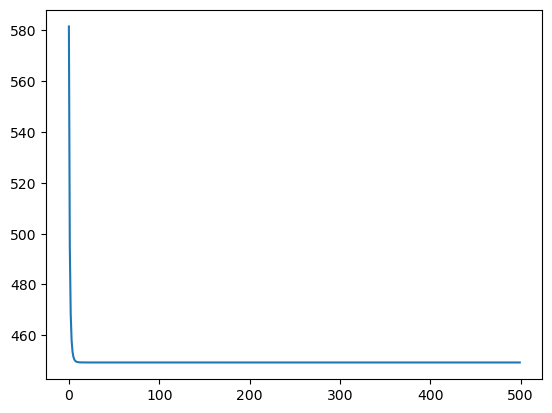

In [26]:
### Insert code here
# ...

origins = np.sum(flow_matrix, axis = 1)
destinations = np.sum(flow_matrix, axis = 0)

production = np.ones((len(municipalities),))
attraction = np.ones((len(municipalities),))

iterations = np.arange(500)
production_sum = []
attraction_sum = []

for iteration in range(500):
    for i in range(len(municipalities)):
        production[i] = origins[i] / np.sum(attraction * updated_friction_matrix[i,:])
    
    for j in range(len(municipalities)):
        attraction[j] = destinations[j] / np.sum(production * updated_friction_matrix[:,j])

    production_sum.append(np.sum(production))
    attraction_sum.append(np.sum(attraction))

plt.plot(iterations, attraction_sum)

**Task**: Calculate the resulting flows of your model. Compare the flows with the reference data, and also compare origin and destination flows in two additional plots.

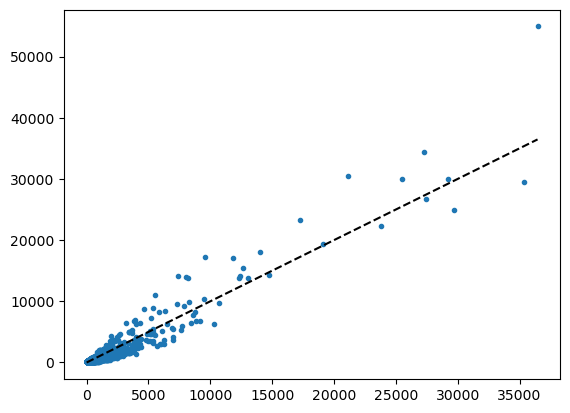

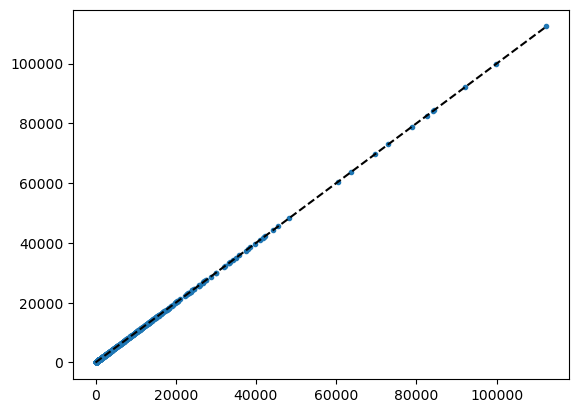

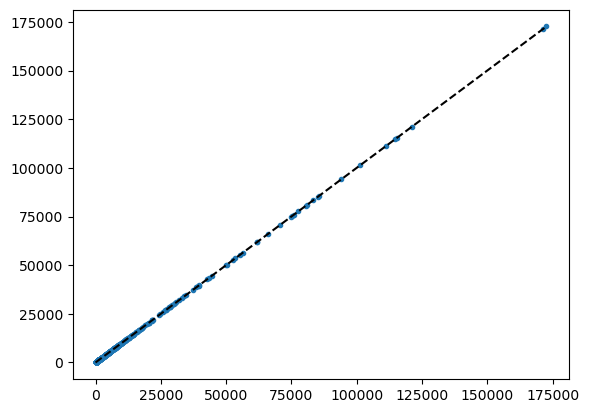

In [27]:
### Insert code here
# ...

F = np.copy(updated_friction_matrix)

for i in range(len(municipalities)):
    F[i,:] *= origins[i] / np.sum(attraction * updated_friction_matrix[i,:])

for j in range(len(municipalities)):
    F[:,j] *= destinations[j] / np.sum(production * updated_friction_matrix[:,j])

plt.figure()
plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 1), np.sum(F, axis = 1), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 1))], [0, np.max(np.sum(flow_matrix, axis = 1))], "k--")

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 0), np.sum(F, axis = 0), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 0))], [0, np.max(np.sum(flow_matrix, axis = 0))], "k--")

**Task**: Do you remeber the initial data frame `df_commutes`? Add a new column to this data frame into which you write your latest modeling results. Show the data frame.

In [28]:
### Insert code here
# ...

df_flow = df_commutes.copy()
df_flow["model"] = F.reshape((-1,))
df_flow

weight        model
origin_id destination_id                          
75101     75101           3179.161525  2365.142735
          75102            363.425022   160.442610
          75103             68.745733    67.629694
          75104            113.951745    89.805893
          75105             83.242573   103.733528
...                               ...          ...
95690     95676              0.000000     0.157332
          95678              0.000000     0.013905
          95680              0.000000     0.124401
          95682              0.000000     0.001008
          95690             14.846050     1.716657

[1656369 rows x 2 columns]

Save the data set for the next exercise.

In [29]:
df_flow.to_parquet("flow.parquet")

**Congratulations!** You can now solve exercise 2.3 of the course project.